#Predicting Tesla stock prices using historical Tesla stock data from:
https://www.wsj.com/market-data/quotes/TSLA/historical-prices

Tesla in recent years has been a very volatile stock, increasing an incredidble amount because of hype, individual investors, and demand for vehicles. I am curious what a prediction model would say about a stock as volatile as TSLA.

This project will attempt to maximize gains, thus maximize true positives (days the model predicted the stock will go up and it infact did go up). The outputs will tell us how many days someone should buy at market open because the stock will close at a higher price later that day.

In [ ]:
import pandas as pd
import matplotlib as mpd
import numpy as np
!pip install scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [ ]:
tsla = pd.read_csv('https://raw.githubusercontent.com/jortiz01/ContributionData/main/HistoricalPrices.csv')

In [ ]:
tsla

,Date,Open,High,Low,Close,Volume
0,5/20/2022,713.990,721.582,633.0000,663.900,4.832444e+07
1,5/19/2022,707.000,734.000,694.1100,709.420,3.009889e+07
2,5/18/2022,744.520,760.500,700.8100,709.810,2.927060e+07
3,5/17/2022,747.360,764.480,728.8500,761.610,2.674537e+07
4,5/16/2022,767.160,769.760,719.0885,724.370,2.869951e+07
...,...,...,...,...,...,...
2968,8/6/2010,4.020,4.032,3.9040,3.918,3.710690e+06
2969,8/5/2010,4.308,4.310,4.0100,4.090,3.981900e+06
2970,8/4/2010,4.390,4.436,4.1700,4.252,4.603780e+06
2971,8/3/2010,4.200,4.390,4.1640,4.390,6.155115e+06


#Prepare Data


In [ ]:
#Renaming columns because words like Close and Open was not initially working

tsla.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

In [ ]:
tsla['Open']

0       713.990
1       707.000
2       744.520
3       747.360
4       767.160
         ...   
2968      4.020
2969      4.308
2970      4.390
2971      4.200
2972      4.100
Name: Open, Length: 2973, dtype: float64

In [ ]:
tsla.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [ ]:
tsla['Date'] = pd.to_datetime(tsla['Date'])

In [ ]:
tsla = tsla.sort_values(by='Date')
tsla

,Date,Open,High,Low,Close,Volume
2972,2010-08-02,4.100,4.194,4.0666,4.184,3.595725e+06
2971,2010-08-03,4.200,4.390,4.1640,4.390,6.155115e+06
2970,2010-08-04,4.390,4.436,4.1700,4.252,4.603780e+06
2969,2010-08-05,4.308,4.310,4.0100,4.090,3.981900e+06
2968,2010-08-06,4.020,4.032,3.9040,3.918,3.710690e+06
...,...,...,...,...,...,...
4,2022-05-16,767.160,769.760,719.0885,724.370,2.869951e+07
3,2022-05-17,747.360,764.480,728.8500,761.610,2.674537e+07
2,2022-05-18,744.520,760.500,700.8100,709.810,2.927060e+07
1,2022-05-19,707.000,734.000,694.1100,709.420,3.009889e+07


In [ ]:
tsla.set_index('Date', inplace = True)

In [ ]:
tsla

,Open,High,Low,Close,Volume
Date,,,,,
2010-08-02,4.100,4.194,4.0666,4.184,3.595725e+06
2010-08-03,4.200,4.390,4.1640,4.390,6.155115e+06
2010-08-04,4.390,4.436,4.1700,4.252,4.603780e+06
2010-08-05,4.308,4.310,4.0100,4.090,3.981900e+06
2010-08-06,4.020,4.032,3.9040,3.918,3.710690e+06
...,...,...,...,...,...
2022-05-16,767.160,769.760,719.0885,724.370,2.869951e+07
2022-05-17,747.360,764.480,728.8500,761.610,2.674537e+07
2022-05-18,744.520,760.500,700.8100,709.810,2.927060e+07


#Shifting Data

Creating a new df. Stock will state whether the previous day closed higher or lower then the current date. Will shift data by one day to check close prices. This will allow to predict next day price instead of predicting same day price with same day data.

In [ ]:
stock = tsla[['Close']]
stock = stock.rename(columns = {'Close' : 'Real_Close'})
stock['Target'] = tsla.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

#Checking for class inbalance
stock['Target'].value_counts()

1.0    1538
0.0    1434
Name: Target, dtype: int64

Shifting the data to place the previous day's close price on the next day's row.

In [ ]:
tslaShift = tsla.copy()

In [ ]:
tslaShift = tslaShift.shift(1)

In [ ]:
predictors = ['Close', 'High','Low','Open','Volume']
stock = stock.join(tslaShift[predictors]).iloc[1:]

New stock df has a "Close" column of the previous close. The Real_Close column can be considered data that would not be known on the given date. Any date would only know the price of the previous day close, not that date's close.

In [ ]:
stock.head()

,Real_Close,Target,Close,High,Low,Open,Volume
Date,,,,,,,
2010-08-03,4.390,1.0,4.184,4.194,4.0666,4.100,3595724.946
2010-08-04,4.252,0.0,4.390,4.390,4.1640,4.200,6155114.908
2010-08-05,4.090,0.0,4.252,4.436,4.1700,4.390,4603779.931
2010-08-06,3.918,0.0,4.090,4.310,4.0100,4.308,3981899.940
2010-08-09,3.920,1.0,3.918,4.032,3.9040,4.020,3710689.944


#Creating Models and Training Data

Using a Classifier because data is either 1 for higher than previous close or 0 for lower than previous close.

In [ ]:
#initialize the Random Forest Classifier
#Will use 100 decision trees and average the results
#min_samples_split prevents from overfitting

In [ ]:
model = RandomForestClassifier(n_estimators = 100, min_samples_split=200, random_state = 1,class_weight='balanced')

train = stock.iloc[:-100] 
test = stock.iloc[-100:]

model.fit(train[predictors], train['Target'])

RandomForestClassifier(class_weight='balanced', min_samples_split=200,
                       random_state=1)

In [ ]:
#Precision will be number of days model said it would go up and actually did go up

In [ ]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [ ]:
precision_score(test['Target'], preds)

0.46808510638297873

In [ ]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined

,Target,Predictions
Date,,
2021-12-29,0.0,1.0
2021-12-30,0.0,1.0
2021-12-31,0.0,1.0
2022-01-03,1.0,1.0
2022-01-04,0.0,0.0
...,...,...
2022-05-16,0.0,1.0
2022-05-17,1.0,1.0
2022-05-18,0.0,1.0


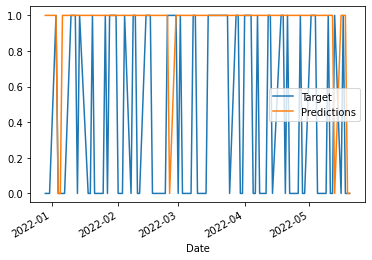

In [ ]:
combined.plot()

#BackTestng

In [ ]:
def backtest(stock, model, predictors, start = 500, step = 50):
  predictions = []
  for i in range(start, stock.shape[0], step):

    train = stock.iloc[0:i].copy()
    test = stock.iloc[i:(i+step)].copy()

    model.fit(train[predictors], train["Target"])

    preds = model.predict_proba(test[predictors])[:,1]
    #returns a 2d array probability the price will go up (1) or go down (0)
    #will only take 2nd column (prob price will increase) since both values equal 1
    
    preds = pd.Series(preds, index = test.index)

    #Setting a high confidence level of .6 to maximize True Positives
    #True positive is a day the prediction said the price would go up and it did

    preds[preds > .6] = 1
    preds[preds <= .6] = 0

    #combining for clarity
    combined = pd.concat({'Target': test["Target"], "Predictions" : preds}, axis = 1)
    predictions.append(combined)
  
  return pd.concat(predictions)



In [ ]:
predictions = backtest(stock, model, predictors)

In [ ]:
predictions['Predictions'].value_counts()

0.0    2163
1.0     309
Name: Predictions, dtype: int64

This prediction model gives 2163 days the price of TSLA will go down and 309 days the price will go up. While these are very few days, the confidence level of .6 hopes to maximize for very confident True Positives (says the price will go up and it does go up).

In [ ]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5275080906148867

This model has a 52.7% accuracy.

#Adding more predictors to effect accuracy

In [ ]:
weekly_mean = stock.rolling(7).mean()
quarterly_mean = stock.rolling(90).mean()
annual_mean = stock.rolling(365).mean()

#Weekly trend is on aveage what is the percentage chance the price will go up on a weekly basis
weekly_trend = stock.shift(1).rolling(7).mean()["Target"]

In [ ]:
stock['Weekly_mean'] = weekly_mean["Close"] / stock['Close']
stock['Quarterly_mean'] = quarterly_mean['Close'] / stock['Close']
stock['Annual_mean'] = annual_mean['Close'] / stock['Close']

stock['Annual_weekly_mean'] = stock['Annual_mean'] / stock['Weekly_mean']
stock['Annual_quarterly_mean'] = stock['Annual_mean'] / stock['Quarterly_mean']
stock['Weekly_trend'] = weekly_trend

stock['open_close_ratio'] = stock['Open'] / stock['Close']
stock['high_close_ratio'] = stock['High'] / stock['Close']
stock['low_close_ratio'] = stock['Low'] / stock['Close']

predictors_full = predictors + ['Weekly_mean', 'Quarterly_mean', 'Annual_mean', 'Annual_weekly_mean', 'Annual_quarterly_mean', 'Weekly_trend', 'open_close_ratio', 'high_close_ratio', 'low_close_ratio']

In [ ]:
predictions = backtest(stock.iloc[365:], model, predictors_full)

In [ ]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5503355704697986

Adding more predictors increased the accuracy to 55%

In [ ]:
predictions['Predictions'].value_counts()

0.0    1958
1.0     149
Name: Predictions, dtype: int64

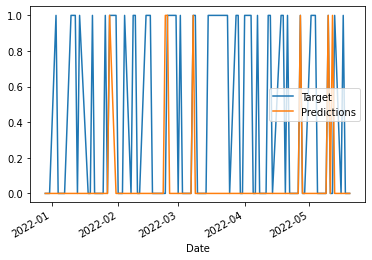

In [ ]:
predictions.iloc[-100:].plot()

This model states that there would be 149 days where we should buy Tesla stock and then sell by market close. Buying on these 149 days and selling on market close would maximize profit with high confidence (0.6+).

#Another Company

Since Tesla has been such a volatile company in terms of market price over the past few years, I would like to run this same model against a more stable company, Google.

In [ ]:
goog = pd.read_csv('https://raw.githubusercontent.com/jortiz01/ContributionData/main/googHistorical.csv')
goog.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
goog['Date'] = pd.to_datetime(goog['Date'])
goog = goog.sort_values(by='Date')
goog.set_index('Date', inplace = True)

In [ ]:
stock = goog[['Close']]
stock = stock.rename(columns = {'Close' : 'Real_Close'})
stock['Target'] = goog.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

#Checking for class inbalance
stock['Target'].value_counts()

1.0    1096
0.0     952
Name: Target, dtype: int64

In [ ]:
googShift = goog.copy()

In [ ]:
googShift = googShift.shift(1)

In [ ]:
predictors = ['Close', 'High','Low','Open','Volume']
stock = stock.join(googShift[predictors]).iloc[1:]

In [ ]:
model = RandomForestClassifier(n_estimators = 100, min_samples_split=200, random_state = 1,class_weight='balanced')

train = stock.iloc[:-100] 
test = stock.iloc[-100:]

model.fit(train[predictors], train['Target'])

RandomForestClassifier(class_weight='balanced', min_samples_split=200,
                       random_state=1)

In [ ]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [ ]:
precision_score(test['Target'], preds)

0.4639175257731959

In [ ]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

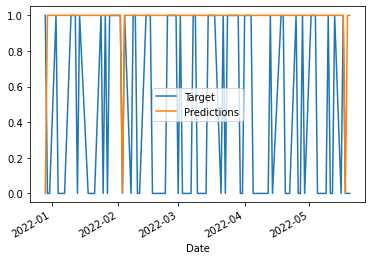

In [ ]:
combined.plot()

In [ ]:
predictions = backtest(stock, model, predictors)

In [ ]:
predictions['Predictions'].value_counts()

0.0    1365
1.0     183
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5300546448087432

In [ ]:
weekly_mean = stock.rolling(7).mean()
quarterly_mean = stock.rolling(90).mean()
annual_mean = stock.rolling(365).mean()

#Weekly trend is on aveage what is the percentage chance the price will go up on a weekly basis
weekly_trend = stock.shift(1).rolling(7).mean()["Target"]

In [ ]:
stock['Weekly_mean'] = weekly_mean["Close"] / stock['Close']
stock['Quarterly_mean'] = quarterly_mean['Close'] / stock['Close']
stock['Annual_mean'] = annual_mean['Close'] / stock['Close']

stock['Annual_weekly_mean'] = stock['Annual_mean'] / stock['Weekly_mean']
stock['Annual_quarterly_mean'] = stock['Annual_mean'] / stock['Quarterly_mean']
stock['Weekly_trend'] = weekly_trend

stock['open_close_ratio'] = stock['Open'] / stock['Close']
stock['high_close_ratio'] = stock['High'] / stock['Close']
stock['low_close_ratio'] = stock['Low'] / stock['Close']

predictors_full = predictors + ['Weekly_mean', 'Quarterly_mean', 'Annual_mean', 'Annual_weekly_mean', 'Annual_quarterly_mean', 'Weekly_trend', 'open_close_ratio', 'high_close_ratio', 'low_close_ratio']

In [ ]:
predictions = backtest(stock.iloc[365:], model, predictors_full)

In [ ]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5416666666666666

In [ ]:
predictions["Predictions"].value_counts()

0.0    1087
1.0      96
Name: Predictions, dtype: int64

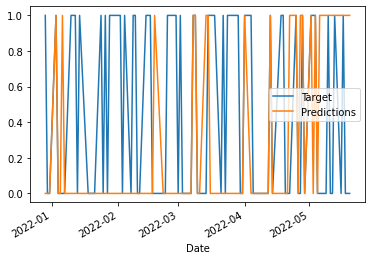

In [ ]:
predictions.iloc[-100:].plot()

Doing the same model to another company like Google, there was a 53% accuracy before adding more predictors, and a 54% accuracy when adding more predictors like means. This gives the user 96 days where they should buy GOOG stock at market open and sell by market close to maximize gains.